# Голова и плечи
рассмортим данный паттерн.

In [1]:
from IPython.display import Image

display(Image(url='https://i0.wp.com/incrypted.net/wp-content/uploads/2019/10/bd31b02728d1dbb8eff33.jpg?fit=640%2C453&ssl=1', 
              width = 1000))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install scipy

In [3]:
df = pd.read_csv("data_btc.csv")
df.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,31.07.2021,"41.553,7","42.201,4","42.285,3","41.066,4","44,65K","-1,54%"
1,30.07.2021,"42.203,4","40.001,1","42.264,4","38.358,4","98,45K","5,50%"
2,29.07.2021,"40.001,4","40.009,0","40.630,7","39.340,8","75,30K","-0,00%"
3,28.07.2021,"40.003,2","39.450,4","40.862,2","38.883,8","148,92K","1,40%"
4,27.07.2021,"39.452,0","37.294,3","39.455,9","36.427,4","100,24K","5,84%"


In [4]:
new_columns = ['date', 'close', 'open', 'high', 'low', 'vol', 'change']
df.columns = new_columns

In [5]:
df = df.iloc[::-1]

In [6]:
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
df = df.set_index('date')
df.head()

,close,open,high,low,vol,change
date,,,,,,
2021-03-01,"49.595,5","45.160,5","49.774,0","45.008,8","137,52K","9,81%"
2021-03-02,"48.424,2","49.595,6","50.191,9","47.100,6","102,10K","-2,36%"
2021-03-03,"50.395,1","48.422,2","52.567,9","48.159,2","44,93K","4,07%"
2021-03-04,"48.428,0","50.388,0","51.757,7","47.521,8","9,56K","-3,90%"
2021-03-05,"48.792,5","48.363,6","49.429,4","46.370,1","113,64K","0,75%"


In [7]:
cols = ['close', 'open', 'high', 'low']

for col in cols:
    df[col] = df[col].str.replace('.', '')
    df[col] = df[col].str.replace(',', '.')
    df[col] = df[col].astype('float')

<ipython-input-7-2b990ab8d867>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('.', '')


In [8]:
df['vol'] = df['vol'].str.replace('K', '')
df['vol'] = df['vol'].str.replace(',', '.')
df['vol'] = df['vol'].astype('float') * 1000

In [9]:
df.head()

,close,open,high,low,vol,change
date,,,,,,
2021-03-01,49595.5,45160.5,49774.0,45008.8,137520.0,"9,81%"
2021-03-02,48424.2,49595.6,50191.9,47100.6,102100.0,"-2,36%"
2021-03-03,50395.1,48422.2,52567.9,48159.2,44930.0,"4,07%"
2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0,"-3,90%"
2021-03-05,48792.5,48363.6,49429.4,46370.1,113640.0,"0,75%"


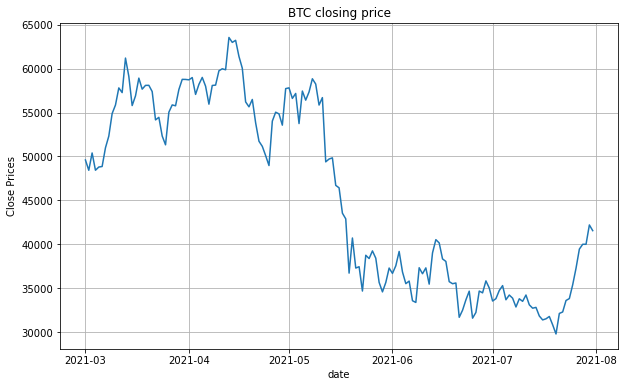

In [10]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('BTC closing price')
plt.show()

# Задание

## Составить алгоритм, который находит паттерн 'голова и плечи' и точку входа для шорт сделки.

## Найдём минимумы и максимумы

In [11]:
import numpy as np
from scipy.signal import argrelextrema

def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['date'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['close']
    
    return max_min

smoothing = 4
window = 10

minmax = get_max_min(df, smoothing, window)
minmax

day_num
4      48792.5
12     61195.3
24     51322.3
27     55765.2
35     58993.4
41     59978.7
43     63540.9
55     48963.6
68     58840.1
74     49839.8
86     39249.2
89     34584.6
99     33382.9
105    40529.4
108    38052.0
116    31594.0
120    35834.7
137    31394.0
141    29793.8
Name: close, dtype: float64

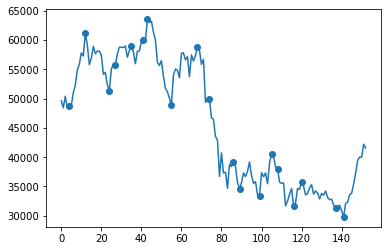

In [12]:
df.reset_index()['close'].plot()
plt.scatter(minmax.index, minmax.values)

## Составим алгоритм где A C E - являются плечами и головой. B D - являются локальными минимумами. 

In [13]:
def get_head_shouldsers(minmaxer):
    mm_res = minmaxer.values
    mm_res
    c_id = mm_res.argsort()[::-1][0]
    a_id = mm_res[:c_id].argsort()[::-1][0]
    e_id = mm_res[c_id+1:].argsort()[::-1][0] + c_id+1
    b_id = np.argmin(mm_res[a_id+1:c_id+1]) + a_id+1
    d_id = np.argmin(mm_res[c_id+1:e_id+1]) + c_id+1
    
    dist = 1000000000
    d = minmax.iloc[d_id]
    enter_sh = 0
    cntr= 0
    for i, val in enumerate(mm_res[e_id+1:]):
        distr = abs(val - d)
        if distr < dist:
            dist = distr
            enter_short = i
            cntr= 0 
        if distr > dist:
            cntr+=1
        if cntr >=2:
            break
    enter_short = enter_short + e_id +1
    return minmaxer.iloc[[a_id, b_id, c_id, d_id, e_id, enter_short]]

answer = get_head_shouldsers(minmax)
answer

day_num
12    61195.3
24    51322.3
43    63540.9
55    48963.6
68    58840.1
74    49839.8
Name: close, dtype: float64

## enter_short - вход для шорт сделки.

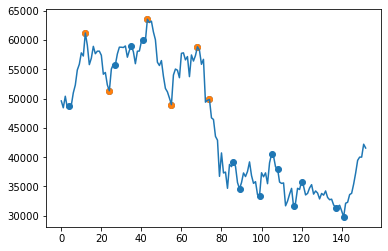

In [14]:
df.reset_index()['close'].plot()
plt.scatter(minmax.index, minmax.values)
plt.scatter(answer.index,answer.values)

#plt.scatter(res_.index, ans)
#plt.plot(df.index, df['close'])